# Extent of marginal stability

In [1]:
%autoreload 2
%matplotlib inline
%load_ext watermark

import cf_xarray
import dask
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.units as munits
import numpy as np
import pandas as pd
import seawater as sw
import xarray as xr
import xgcm
from holoviews import opts

import pump

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 140
munits.registry[np.datetime64] = mdates.ConciseDateConverter()

xr.set_options(keep_attrs=True)


xr.DataArray([1.0])

gcmdir = "/glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year/OUTPUT/"  # MITgcm output directory
stationdirname = gcmdir

%watermark -iv

numpy      : 1.21.1
pandas     : 1.3.1
matplotlib : 3.4.2
pump       : 0.1
xgcm       : 0.5.1.dev138+g3b80993
cf_xarray  : 0.6.0
dcpy       : 0.1
seawater   : 3.3.4
dask       : 2021.7.2
xarray     : 0.19.0
distributed: 2021.7.2



In [2]:
import ncar_jobqueue

if "client" in locals():
    client.close()
    del client
#if "cluster" in locals():
#    cluster.close()

#env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}

# cluster = distributed.LocalCluster(
#    n_workers=8,
#    threads_per_worker=1,
#    env=env
# )

if "cluster" in locals():
    del cluster

#cluster = ncar_jobqueue.NCARCluster(
#    project="NCGD0011",
#    scheduler_options=dict(dashboard_address=":9797"),
#)
# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )

import dask_jobqueue
cluster = dask_jobqueue.PBSCluster(
    cores=1, # The number of cores you want
    memory='23GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=23GB', # Specify resources
    project='ncgd0011', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(jobs=4)

In [3]:
client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.206.60:39484' processes=0 threads=0, memory=0 B>

## MITgcm 25 year

In [223]:
surf = False
mombudget = False
heatbudget = False
state = True

# start date for les; noon is a good time (it is before sunrise)
sim_time = pd.Timestamp("2003-01-01 12:00:00")

# ADD a 5 day buffer here (:] all kinds of bugs at the beginning and end)
les_time_length = 366*15 # (days); length of time for forcing/pushing files

# don't change anything here
output_start_time = pd.Timestamp("1999-01-01")  # don't change
firstfilenum = (
    (
        sim_time - pd.Timedelta("1D") - output_start_time
    )  # add one day offset to avoid bugs
    .to_numpy()
    .astype("timedelta64[D]")
    .astype("int")
)
lastfilenum = firstfilenum + les_time_length


def gen_file_list(suffix):
    files = [
        f"{gcmdir}/File_{num}_{suffix}.nc"
        for num in range(firstfilenum - 1, lastfilenum + 1)
    ]

    return files


files = []
if surf:
    files += gen_file_list(suffix="etan") + gen_file_list(suffix="surf")
if mombudget:
    files += gen_file_list(suffix="ub") + gen_file_list(suffix="vb")
if heatbudget:
    files += gen_file_list(suffix="hb")
if state:
    files += gen_file_list(suffix="buoy")

coords = pump.model.read_mitgcm_coords(gcmdir)

# grid metrics
# verify at http://gallery.pangeo.io/repos/xgcm/xgcm-examples/02_mitgcm.html#
metrics = (
    pump.model.read_metrics(gcmdir)
    .compute()
    .isel(longitude=slice(40, -40), latitude=slice(40, -40), depth=slice(136))
    .chunk({"latitude": 120, "longitude": 500})
    .drop(["latitude", "longitude", "depth", "dRF"])
    .rename({"depth_left": "RF", "depth": "RC", "latitude": "YC", "longitude": "XC"})
    .isel(RF=slice(136))
)
metrics["rAw"] = metrics.rAw.rename({"XC": "XG"})
metrics["rAs"] = metrics.rAs.rename({"YC": "YG"})

metrics["hFacW"] = metrics.hFacW.rename({"XC": "XG"})
metrics["hFacS"] = metrics.hFacS.rename({"YC": "YG"})

metrics["DXG"] = metrics.DXG.rename({"YC": "YG"})
metrics["DYG"] = metrics.DYG.rename({"XC": "XG"})

metrics["DXC"] = metrics.DXC.rename({"XC": "XG"})
metrics["DYC"] = metrics.DYC.rename({"YC": "YG"})

In [224]:
subsetter = lambda ds: ds.reindex(longitude=[-110, -125, -140, -155], method="nearest")

grid = xgcm.Grid(
    xr.merge(
        [
            coords.cf.reindex(X=[-110, -125, -140, -155], method="nearest"),
            metrics.update(coords).cf.reindex(
                X=[-110, -125, -140, -155], method="nearest"
            ),
        ]
    ),
    periodic=False,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
    metrics={
        "X": ("DXC", "DXG"),
        "Y": ("DYG", "DYC"),
        "Z": ("drF", "drC"),
        ("X", "Y"): ("rAw", "rAs"),
    },
)


ds = (
    xr.open_mfdataset(
        files,
        chunks={"longitude": 20},
        combine="by_coords",
        parallel=True,
        preprocess=subsetter,
    )
    .rename({"latitude": "YC", "longitude": "XC"})
    .update((coords.cf.reindex(X=[-110, -125, -140, -155], method="nearest")).coords)
    .chunk({"time": 120})
)

if surf:
    ds["oceQsw"] = ds.oceQsw.fillna(0)
if mombudget:
    ds["taux"] = 1035 * 2.5 * budgets["Um_Ext"].isel(RC=0)
    ds["tauy"] = 1035 * 2.5 * budgets["Vm_Ext"].isel(RC=0)


# if heatbudget:
#    hb_ren = pump.model.rename_mitgcm_budget_terms(hb, coords).update(coords.coords)


ds["u"] = ds.u.drop("XC").rename({"XC": "XG"})
ds["v"] = ds.v.drop("YC").rename({"YC": "YG"})
ds = ds.drop("depth").rename({"depth": "RC"})

for var in ["w", "KPP_diffusivity"]:
    ds[var] = ds[var].drop("RC").rename({"RC": "RF"})

ds["dens"] = pump.mdjwf.dens(ds.salt, ds.theta, np.array([0.0]))

In [225]:
def print_metrics(grid):
    for k, v in grid._metrics.items():
        metricvars = '\n\t'.join(f'{var.name} at {var.dims}' for var in v)
        print(f"{sorted(tuple(k))!s}: {metricvars}")
        
print_metrics(grid)

['X']: DXC at ('YC', 'XG')
	DXG at ('YG', 'XC')
['Y']: DYG at ('YC', 'XG')
	DYC at ('YG', 'XC')
['Z']: drF at ('RC',)
	drC at ('RF',)
['X', 'Y']: rAw at ('YC', 'XG')
	rAs at ('YG', 'XC')


In [226]:
ds["N2"] = 9.81 / 1035 * grid.derivative(ds.dens, "Z")
ds["S2"] = (
    grid.interp_like(grid.derivative(ds.u, "Z") ** 2, ds.N2)
    + grid.interp_like(grid.derivative(ds.v, "Z") ** 2, ds.N2)
)
ds["Ri"] = ds.N2 / ds.S2

ds = dask.optimize(ds)[0]

ds["Ri"].data = dask.optimize(ds.Ri)[0].data
ds["mld"]  = pump.calc.get_mld(ds.dens)
fordcl = ds[["mld", "Ri"]].cf.chunk({"Z": -1}).unify_chunks()

ds["dcl_base"] = xr.map_blocks(
    pump.calc.get_dcl_base_Ri,
    fordcl,
    template=fordcl.mld,
)

#ds["dcl_base"] = pump.calc.get_dcl_base_Ri(ds, depth_thresh=-250)
ds["dcl"] = ds.mld - ds.dcl_base
ds.dcl.attrs["long_name"] = "DCL"

In [227]:
subset = ds.dcl.persist()

In [228]:
tsmoothed = subset.rolling(time=5, center=True).mean()
extents = pump.calc.find_mi_extent(tsmoothed, "Y")

In [229]:
extents.load().to_netcdf("mi-zone-extents.nc")

(16010.0, 16740.0)

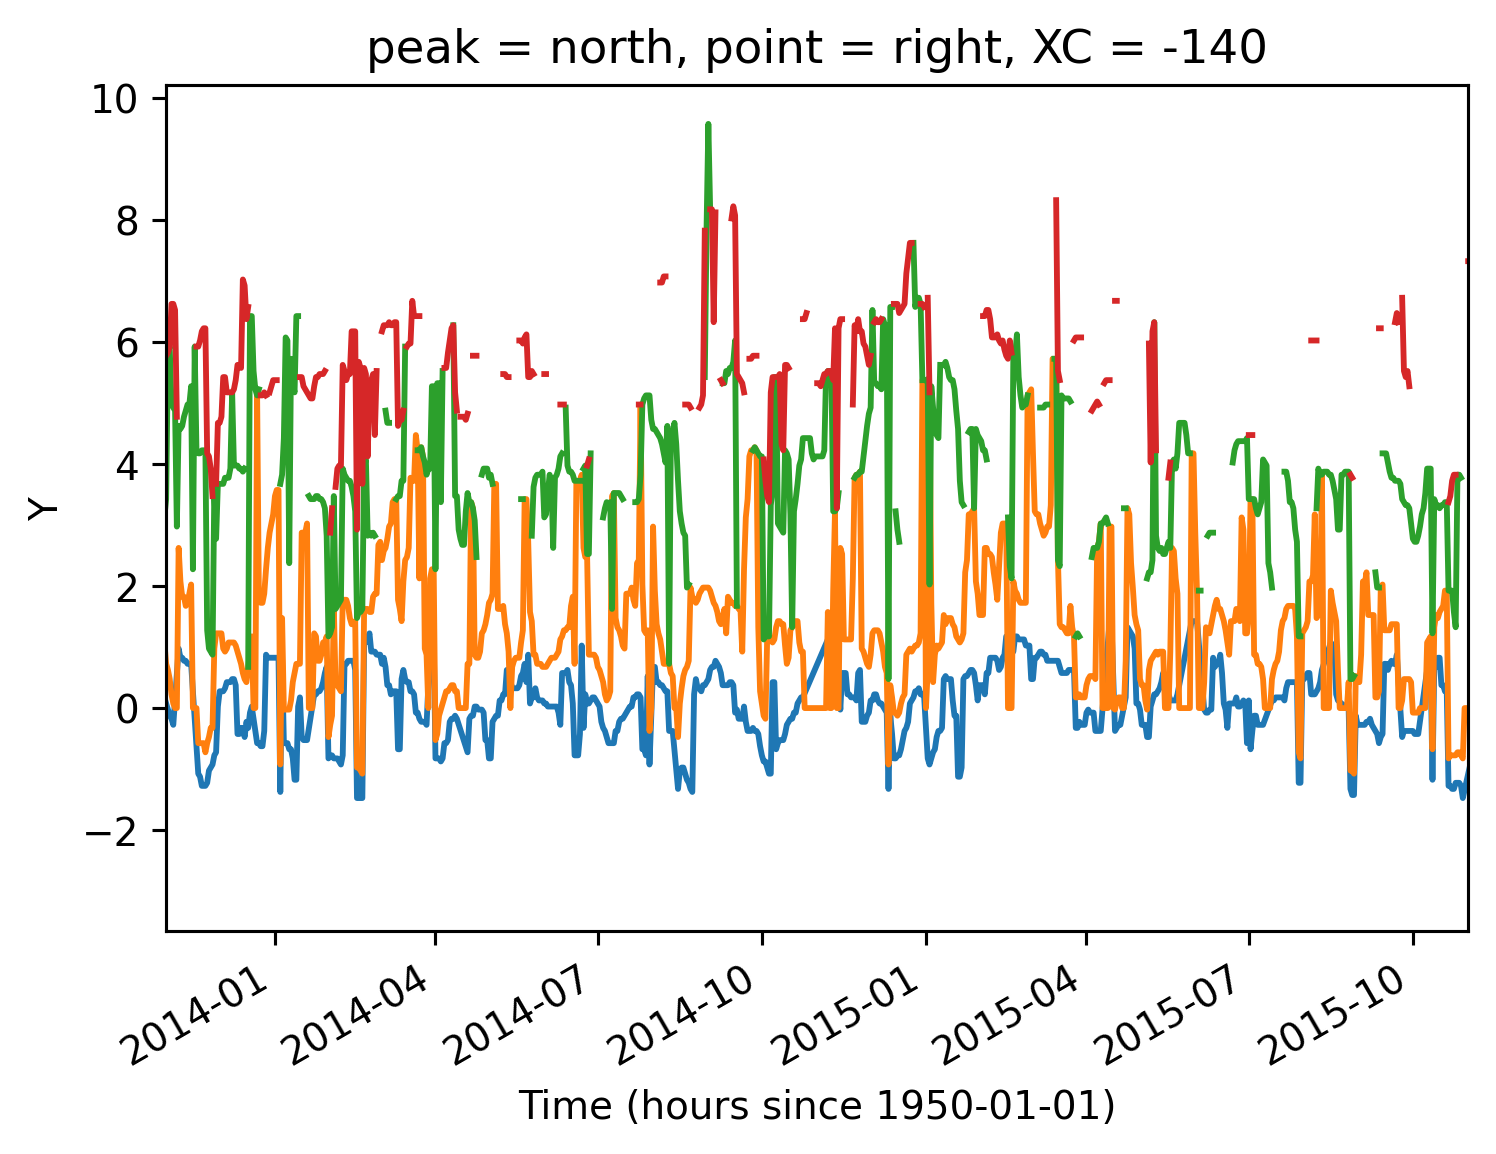

In [283]:
y0.plot()
yp.plot()
yne.plot()
yn.plot()
plt.xlim(["2013-11-01", "2015-11-01"])

In [286]:
ds

<xarray.Dataset>
Dimensions:          (RF: 136, YG: 400, XG: 4, XC: 4, YC: 400, time: 5492, RC: 136)
Coordinates:
  * RF               (RF) float64 0.0 -2.5 -5.0 -7.5 ... -797.0 -851.7 -911.6
  * YG               (YG) float64 -10.0 -9.95 -9.9 -9.85 ... 9.8 9.85 9.9 9.95
  * XG               (XG) int64 -110 -125 -140 -155
  * XC               (XC) int64 -110 -125 -140 -155
  * YC               (YC) float64 -9.975 -9.925 -9.875 ... 9.875 9.925 9.975
  * time             (time) datetime64[ns] 2002-12-29 2002-12-30 ... 2018-01-10
  * RC               (RC) float64 -1.25 -3.75 -6.25 ... -824.4 -881.7 -944.4
Data variables: (12/13)
    theta            (time, RC, YC, XC) float32 dask.array<chunksize=(120, 136, 400, 1), meta=np.ndarray>
    u                (time, RC, YC, XG) float32 dask.array<chunksize=(120, 136, 400, 1), meta=np.ndarray>
    v                (time, RC, YG, XC) float32 dask.array<chunksize=(120, 136, 400, 1), meta=np.ndarray>
    w                (time, RF, YC, XC) float32 dask.array<chunksize=(120, 136, 400, 1), meta=np.ndarray>
    salt             (time, RC, YC, XC) float32 dask.array<chunksize=(120, 136, 400, 1), meta=np.ndarray>
    KPP_diffusivity  (time, RF, YC, XC) float32 dask.array<chunksize=(120, 136, 400, 1), meta=np.ndarray>
    ...               ...
    N2               (time, RF, YC, XC) float32 dask.array<chunksize=(120, 1, 400, 1), meta=np.ndarray>
    S2               (time, RF, YC, XC) float32 dask.array<chunksize=(120, 1, 399, 1), meta=np.ndarray>
    Ri               (time, RF, YC, XC) float32 dask.array<chunksize=(120, 1, 399, 1), meta=np.ndarray>
    mld              (time, YC, XC) float64 dask.array<chunksize=(120, 400, 1), meta=np.ndarray>
    dcl_base         (time, YC, XC) float64 dask.array<chunksize=(120, 399, 1), meta=np.ndarray>
    dcl              (time, YC, XC) float64 dask.array<chunksize=(120, 399, 1), meta=np.ndarray>
Attributes:
    title:              daily snapshot from 1/20 degree Equatorial Pacific MI...
    easting:            longitude
    northing:           latitude
    field_julian_date:  464520
    julian_day_unit:    days since 1950-01-01 00:00:00

In [272]:
yne = cen.sel(peak="eq-north", point="right")
yn = cen.sel(peak="north", point="right")
ytop = np.minimum(yne.fillna(np.inf), yn.fillna(np.inf))
yp_merged = xr.where(~np.isfinite(ytop), yp, ytop)

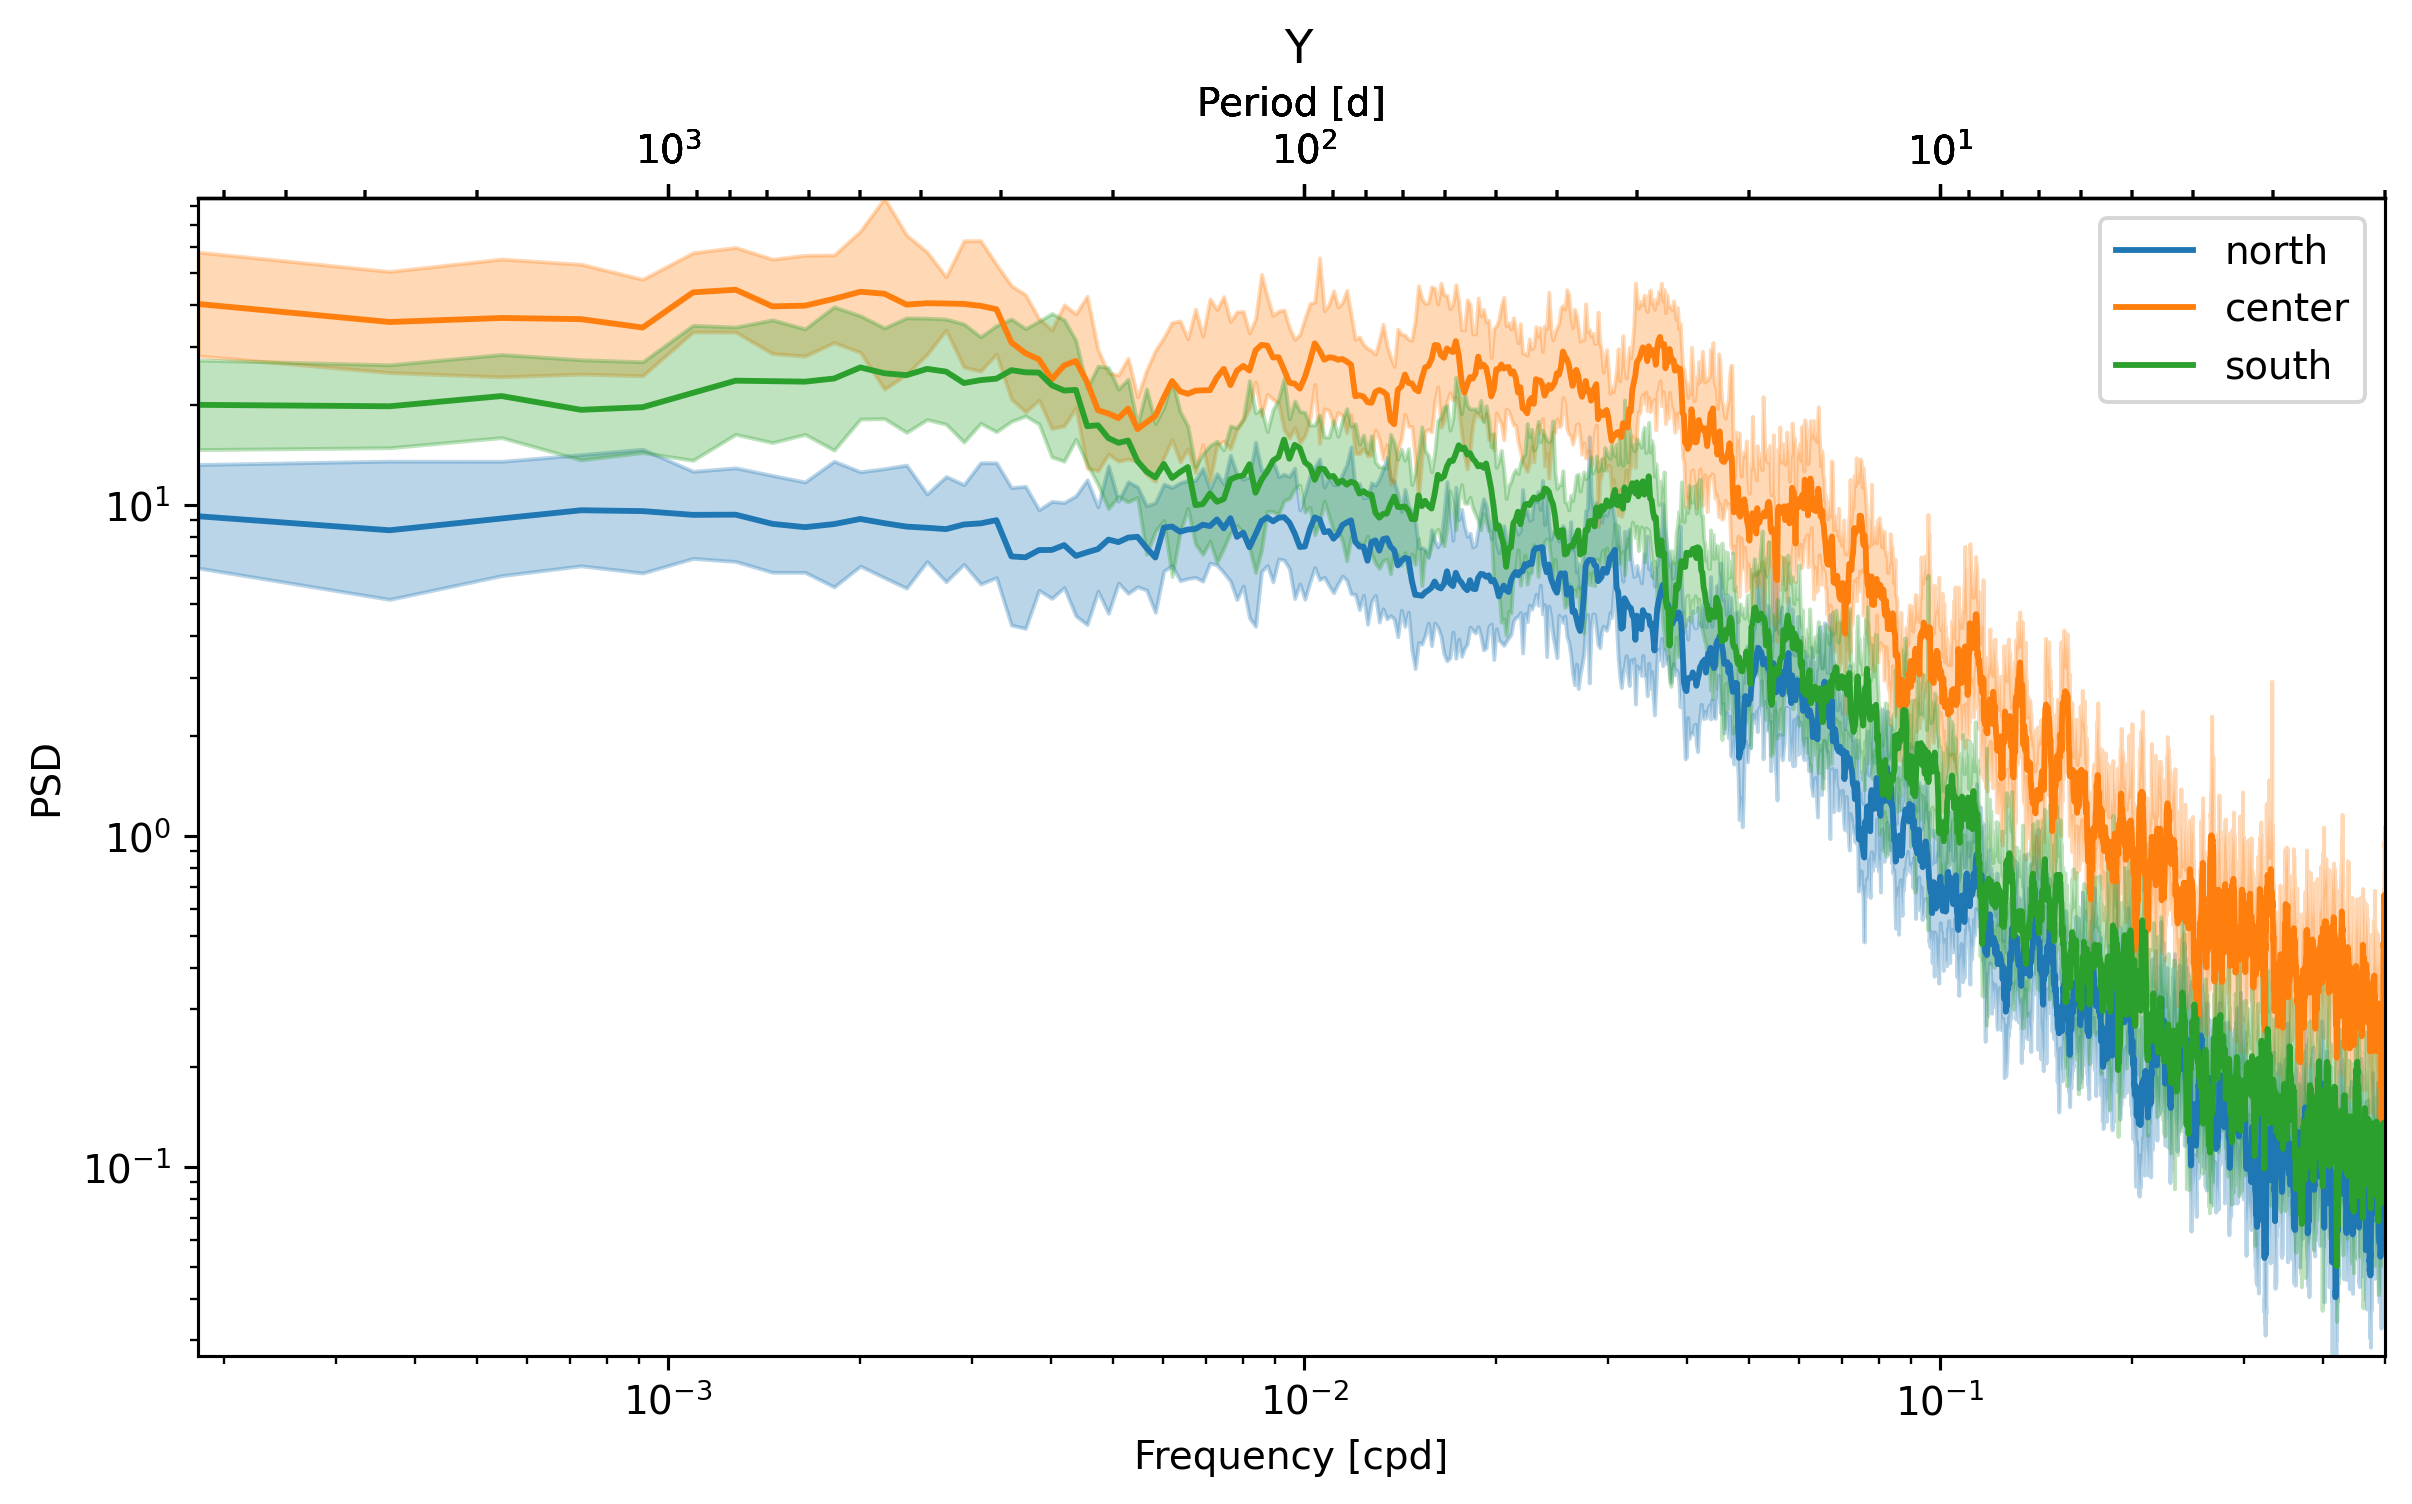

In [291]:
cen = extents.Y.sel(XC=-125)
y0 = cen.sel(peak="eq", point="mid")
y0 = y0.where(y0 > -2).ffill("time")

yp = cen.sel(peak="eq", point="right").ffill("time")
ym = cen.sel(peak="eq", point="left").ffill("time")

_, ax = dcpy.ts.PlotSpectrum(y0, nsmooth=10)
dcpy.ts.PlotSpectrum(yp, ax=ax, nsmooth=10)
dcpy.ts.PlotSpectrum(ym, ax=ax, nsmooth=10)
ax.legend(["north", "center", "south"])

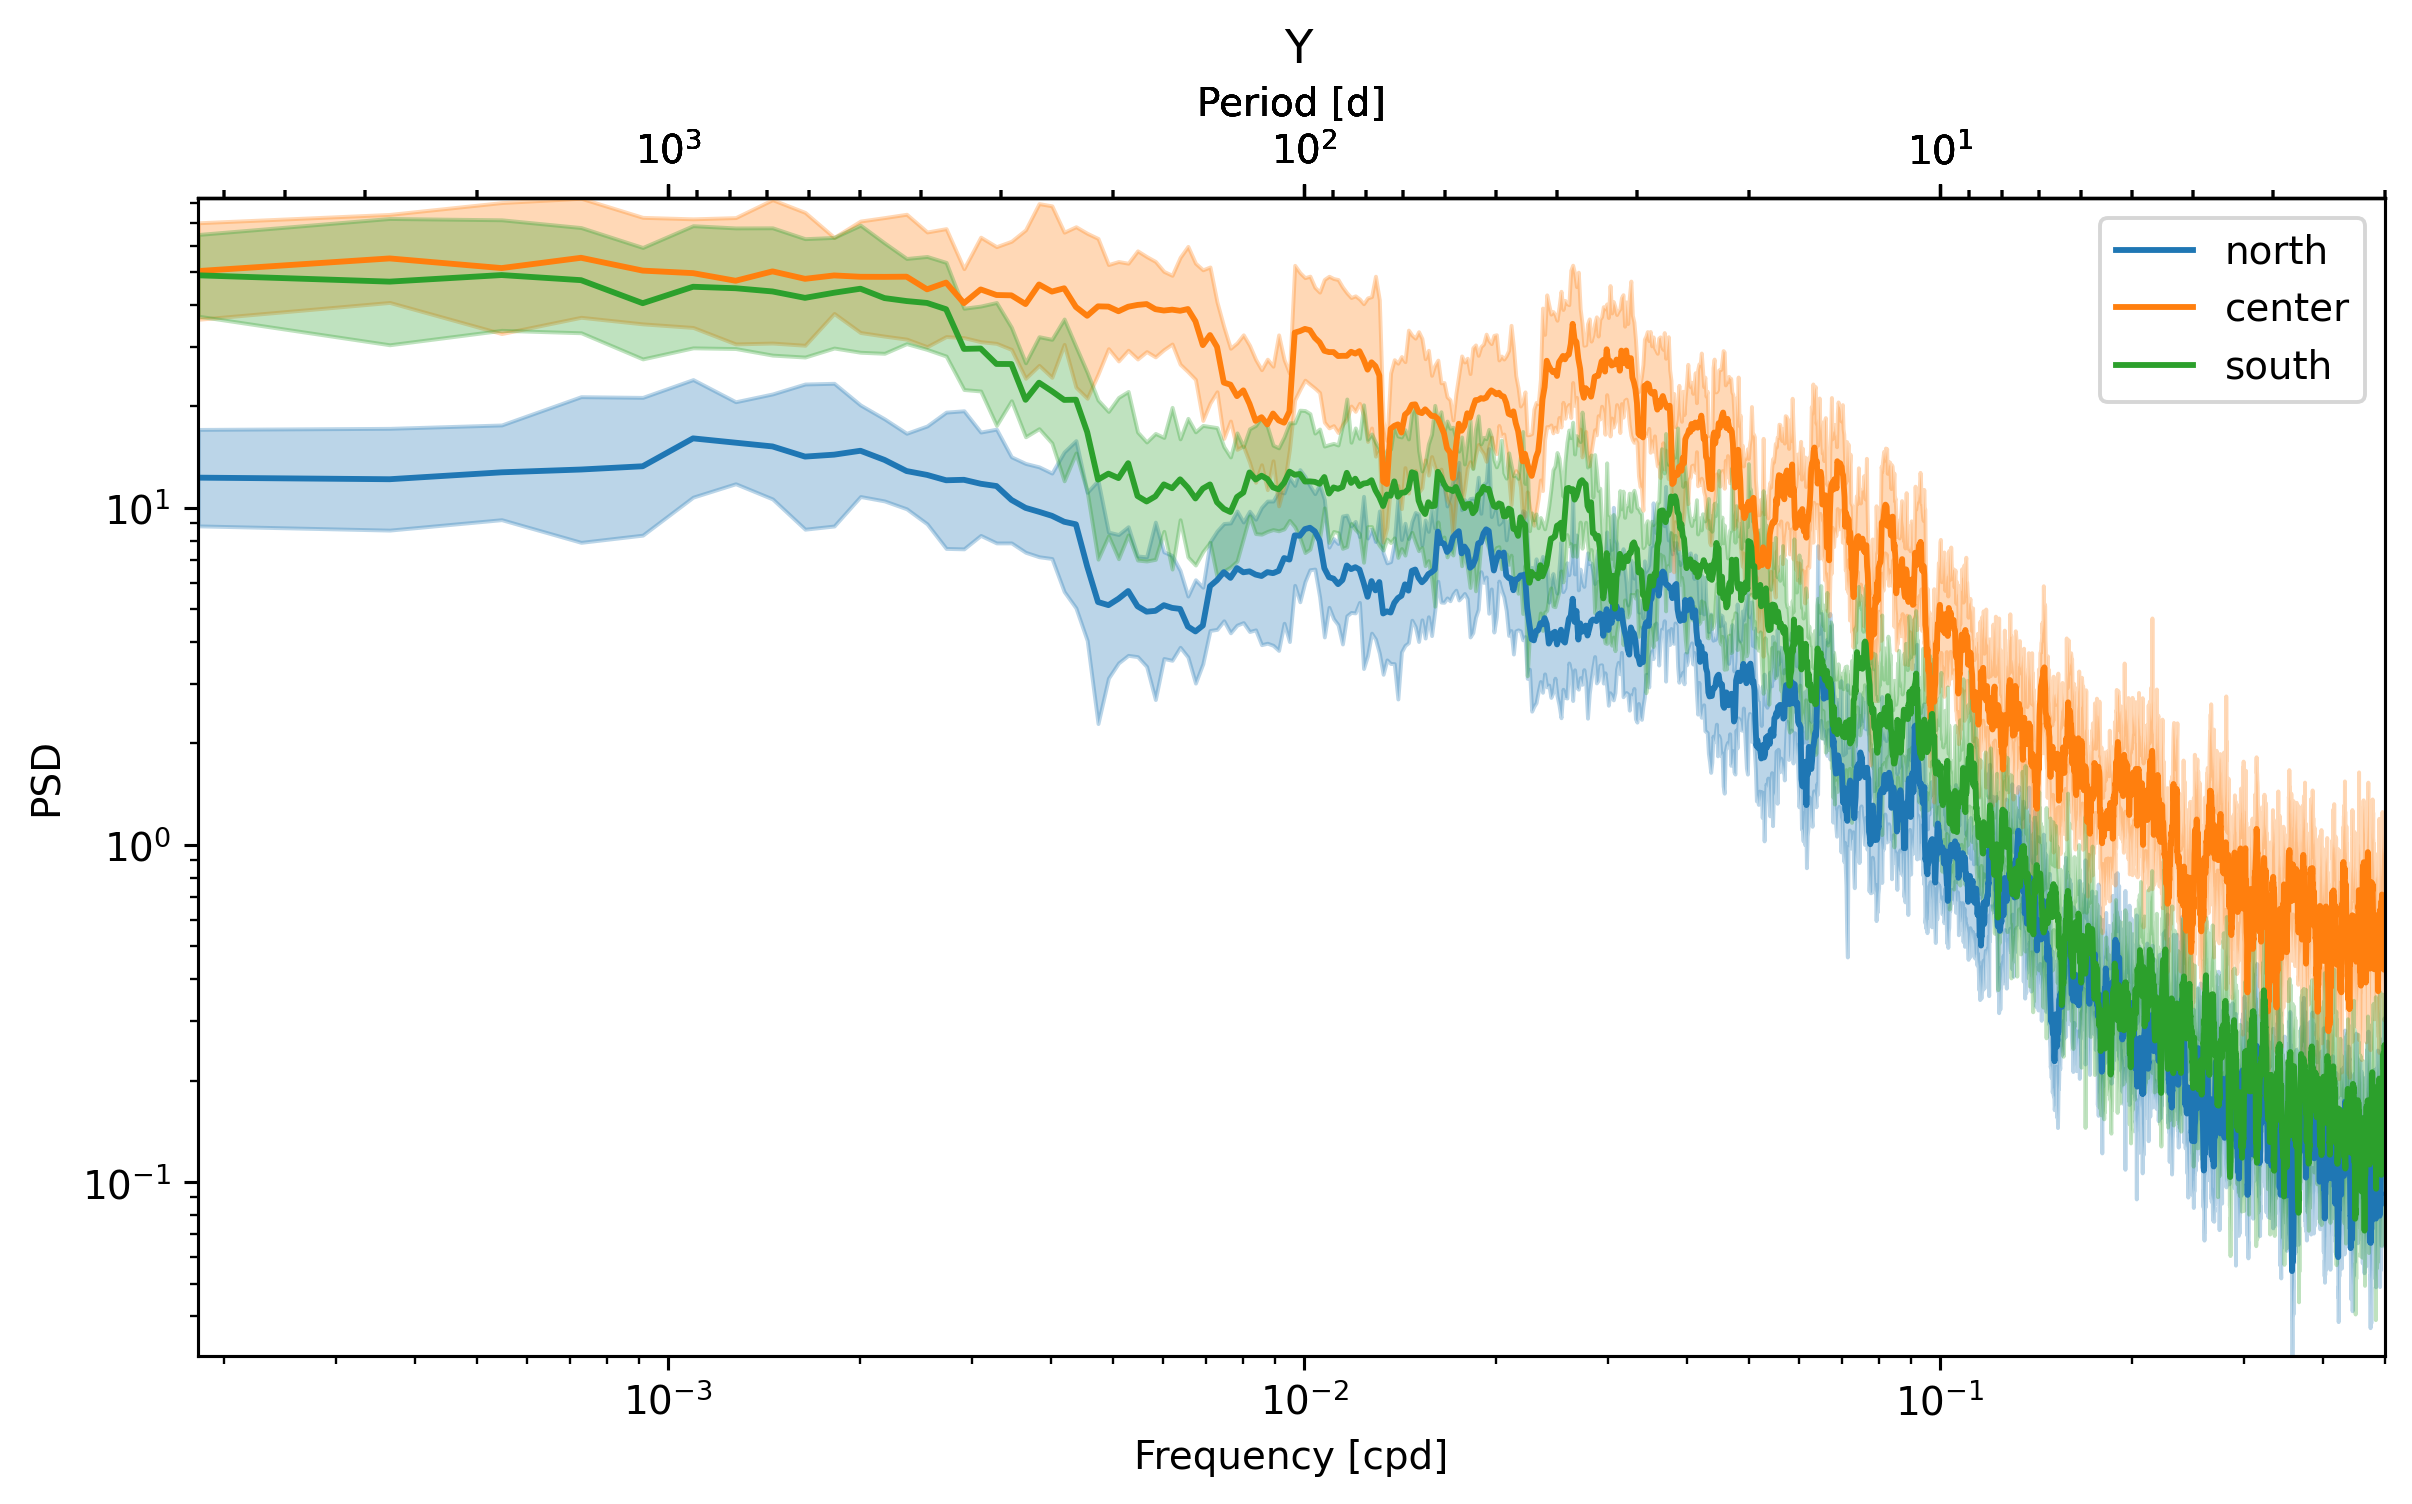

In [289]:
cen = extents.Y.sel(XC=-140)
y0 = cen.sel(peak="eq", point="mid")
y0 = y0.where(y0 > -2).ffill("time")

yp = cen.sel(peak="eq", point="right").ffill("time")
ym = cen.sel(peak="eq", point="left").ffill("time")

_, ax = dcpy.ts.PlotSpectrum(y0, nsmooth=10)
dcpy.ts.PlotSpectrum(yp, ax=ax, nsmooth=10)
dcpy.ts.PlotSpectrum(ym, ax=ax, nsmooth=10)
ax.legend(["north", "center", "south"])

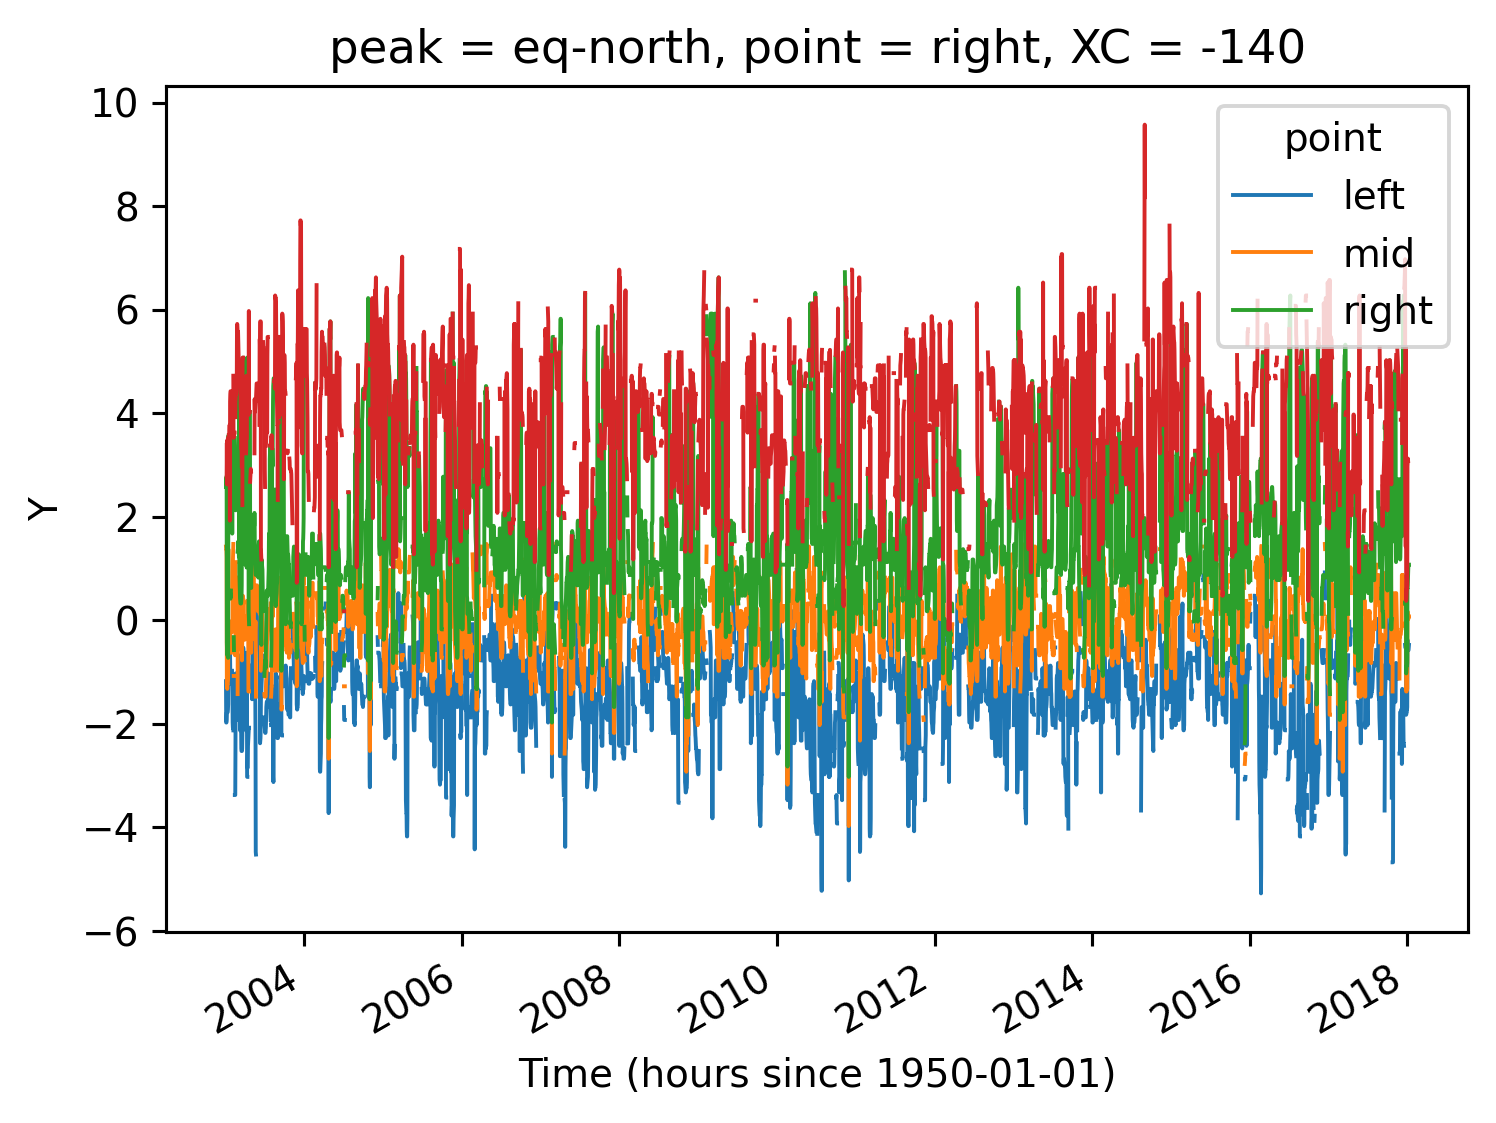

In [239]:
extents.Y.sel(XC=-140).sel(peak="eq").plot.line(x="time", lw=1)
extents.Y.sel(XC=-140).sel(peak="eq-north", point="right").plot.line(x="time", lw=1)

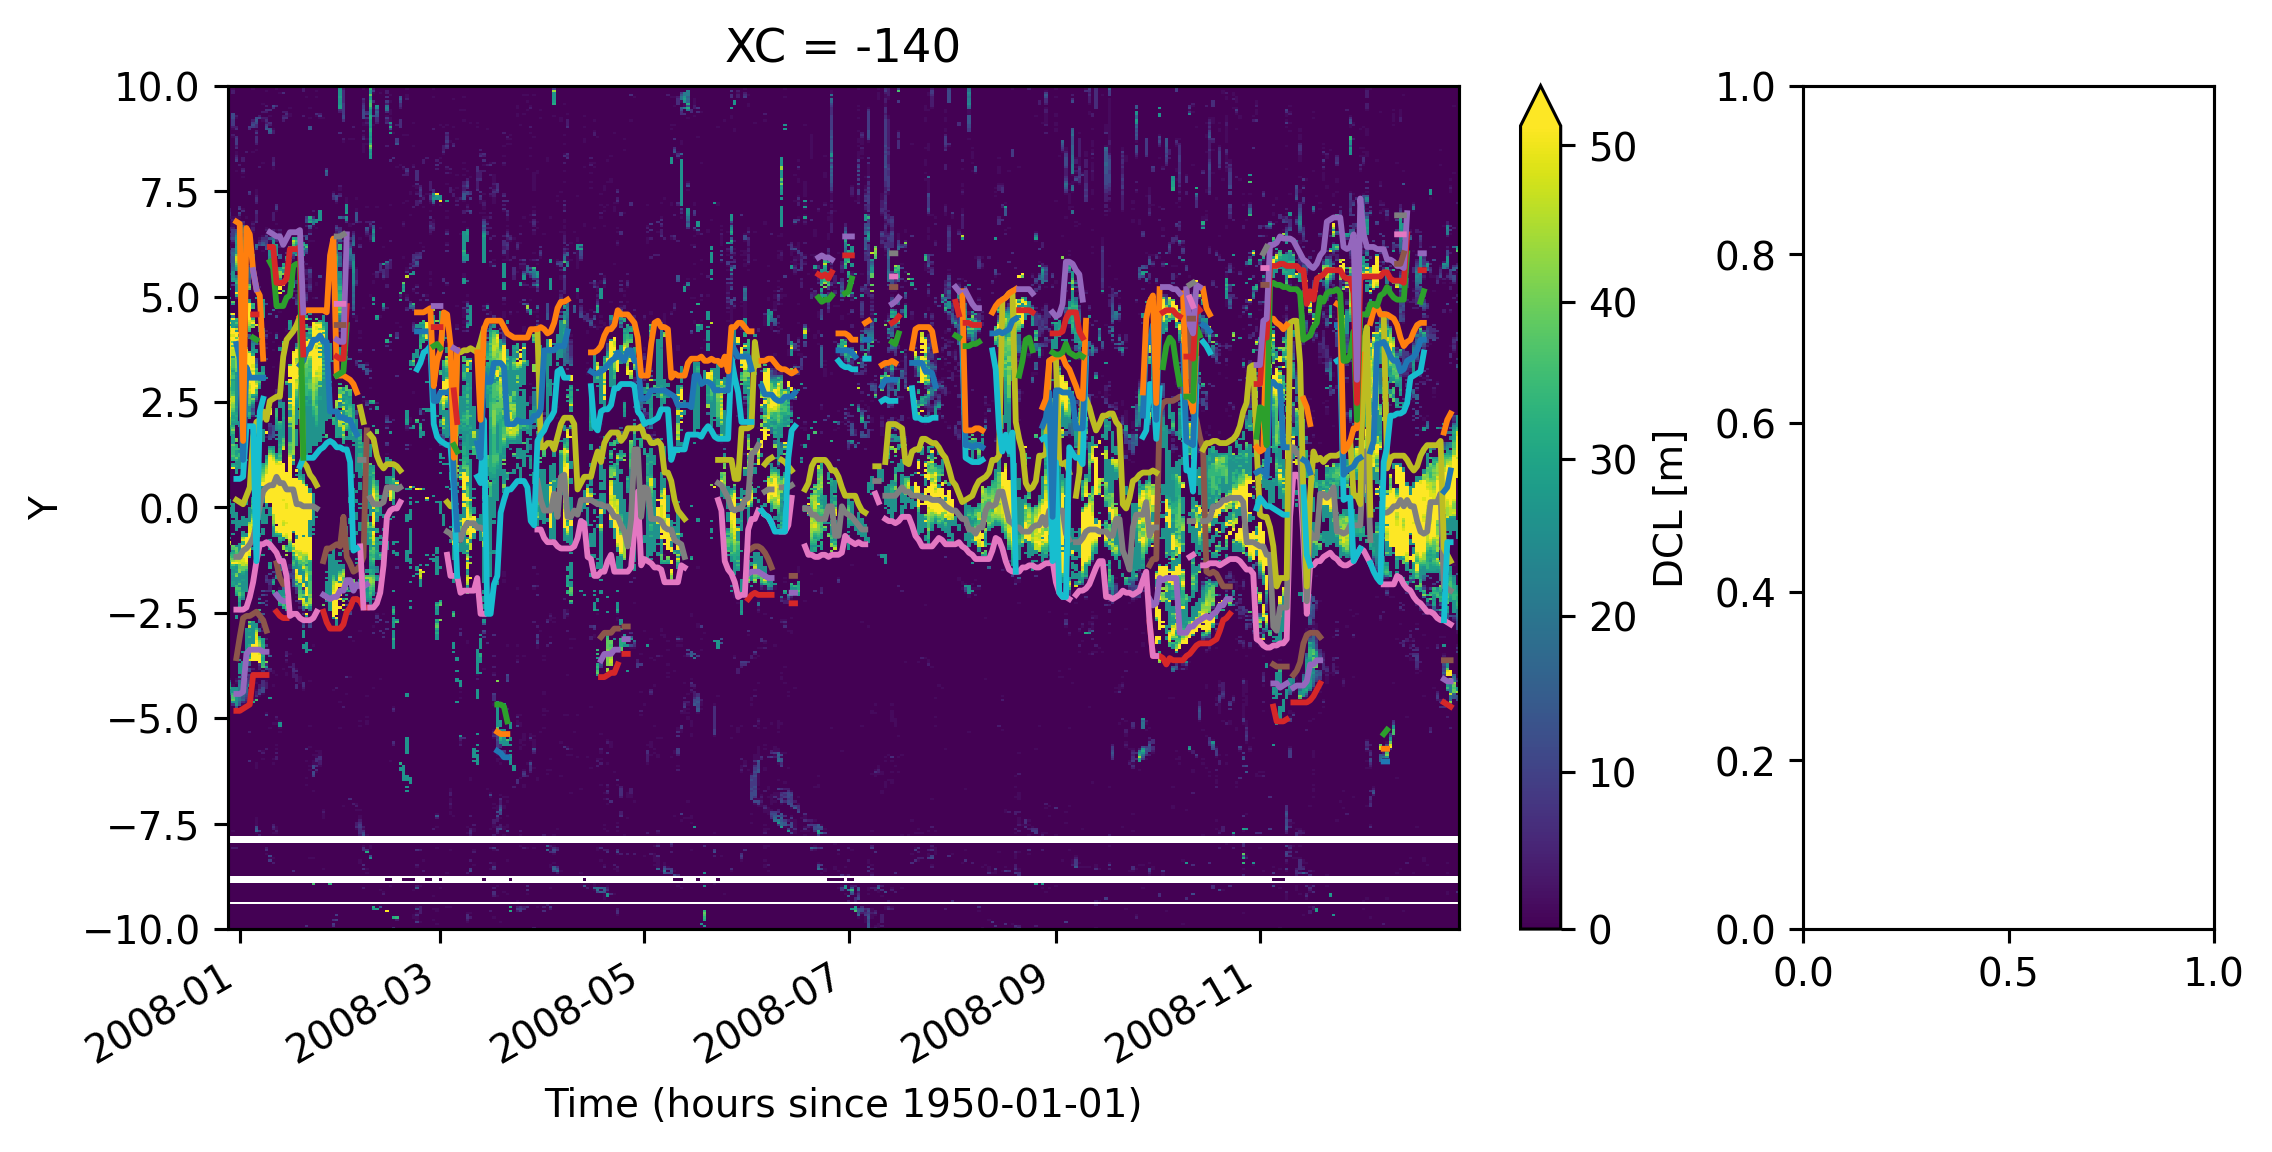

In [188]:
idx = [0, 20, 10, -5, -2]
idx = [-5]


lon = -140
f, ax = plt.subplots(
    1, 2, sharey=False, constrained_layout=True, gridspec_kw={"width_ratios": [3, 1]}
)
subset.cf.sel(X=lon).cf.plot(ax=ax[0], robust=True)
extents.cf.sel(X=lon).Y.stack({"stacked": ["peak", "point"]}).plot.line(
    x="time", ax=ax[0], add_legend=False
)

#for i in idx:
#    ax[0].plot([subset.time.data[i]] * 2, [-10, 10])
#    extent = find_extent(
#        tsmoothed.isel(time=i).compute(),
#        dim="Y",
#        debug=True,
#        ax=ax[1],
#    )

f.set_size_inches((8, 4))
#extents.isel(time=i).compute()

In [206]:
extents.to_netcdf("mi-zone-lat-extents-2008.nc")

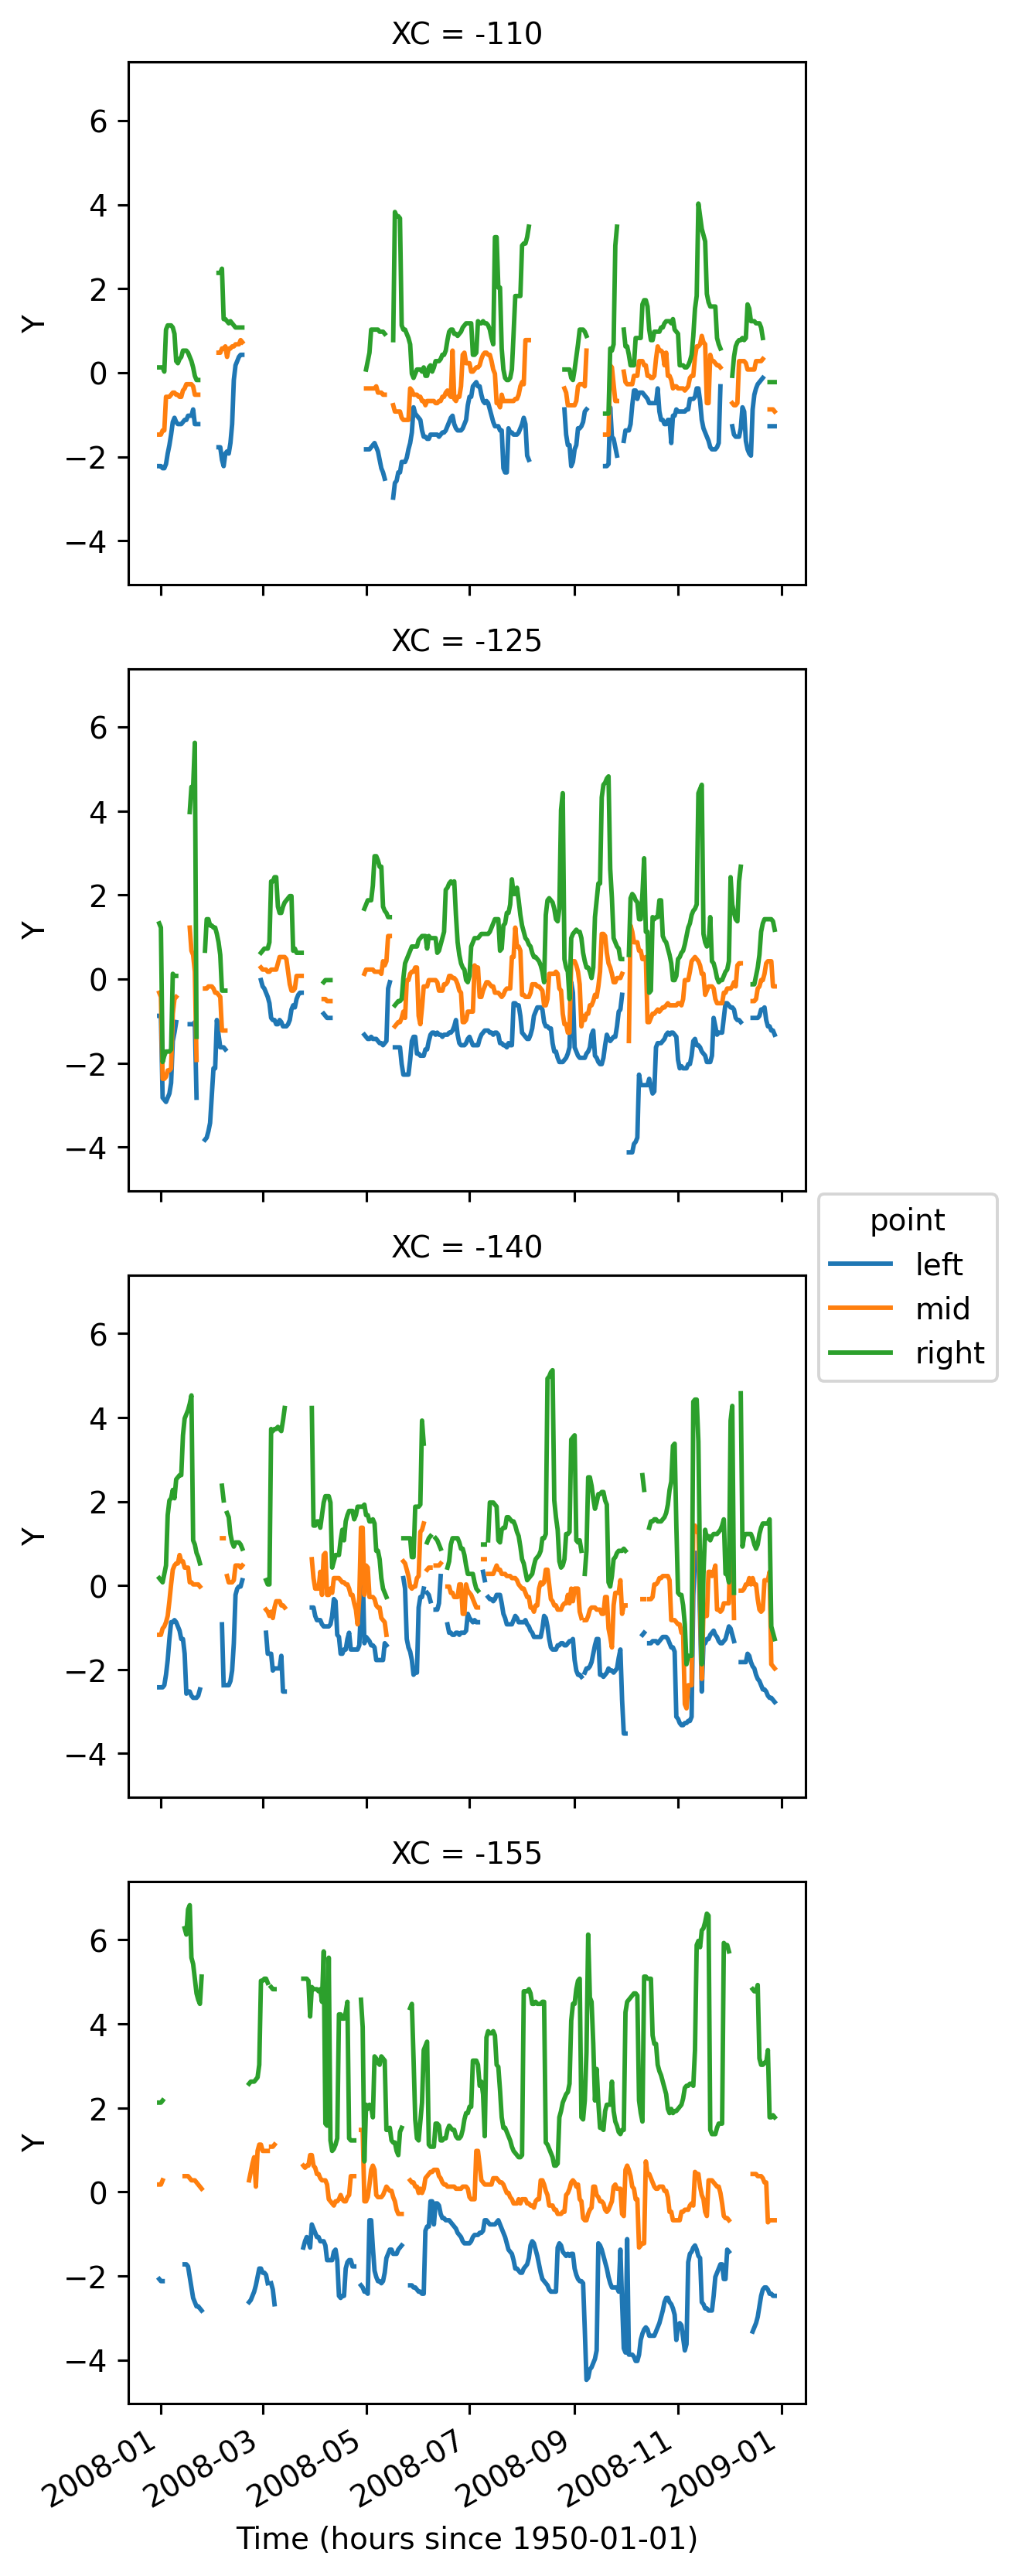

In [199]:
extents.Y.sel(peak="eq").plot.line(row="XC", x="time")

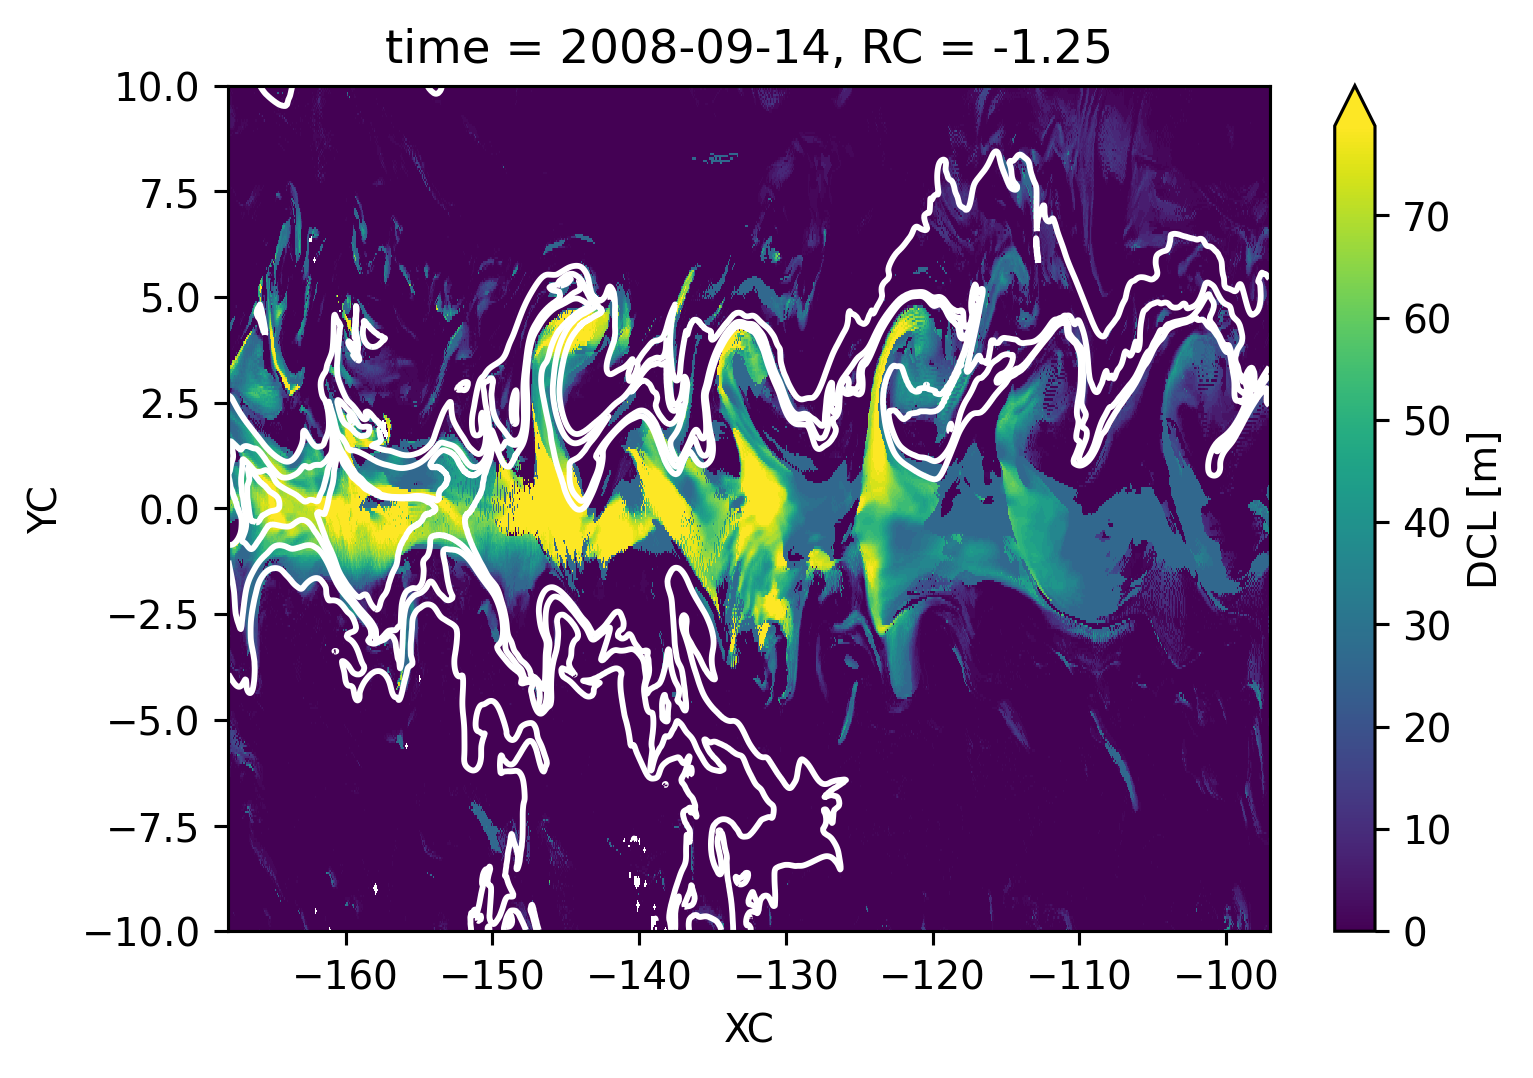

In [94]:
ds.dcl.isel(time=260).cf.plot(robust=True)
(
    ds.theta.cf.sel(Z=0, method="nearest")
    .isel(time=260)
    .cf.plot.contour(levels=[26, 26.25, 26.5, 27], colors="w")
)

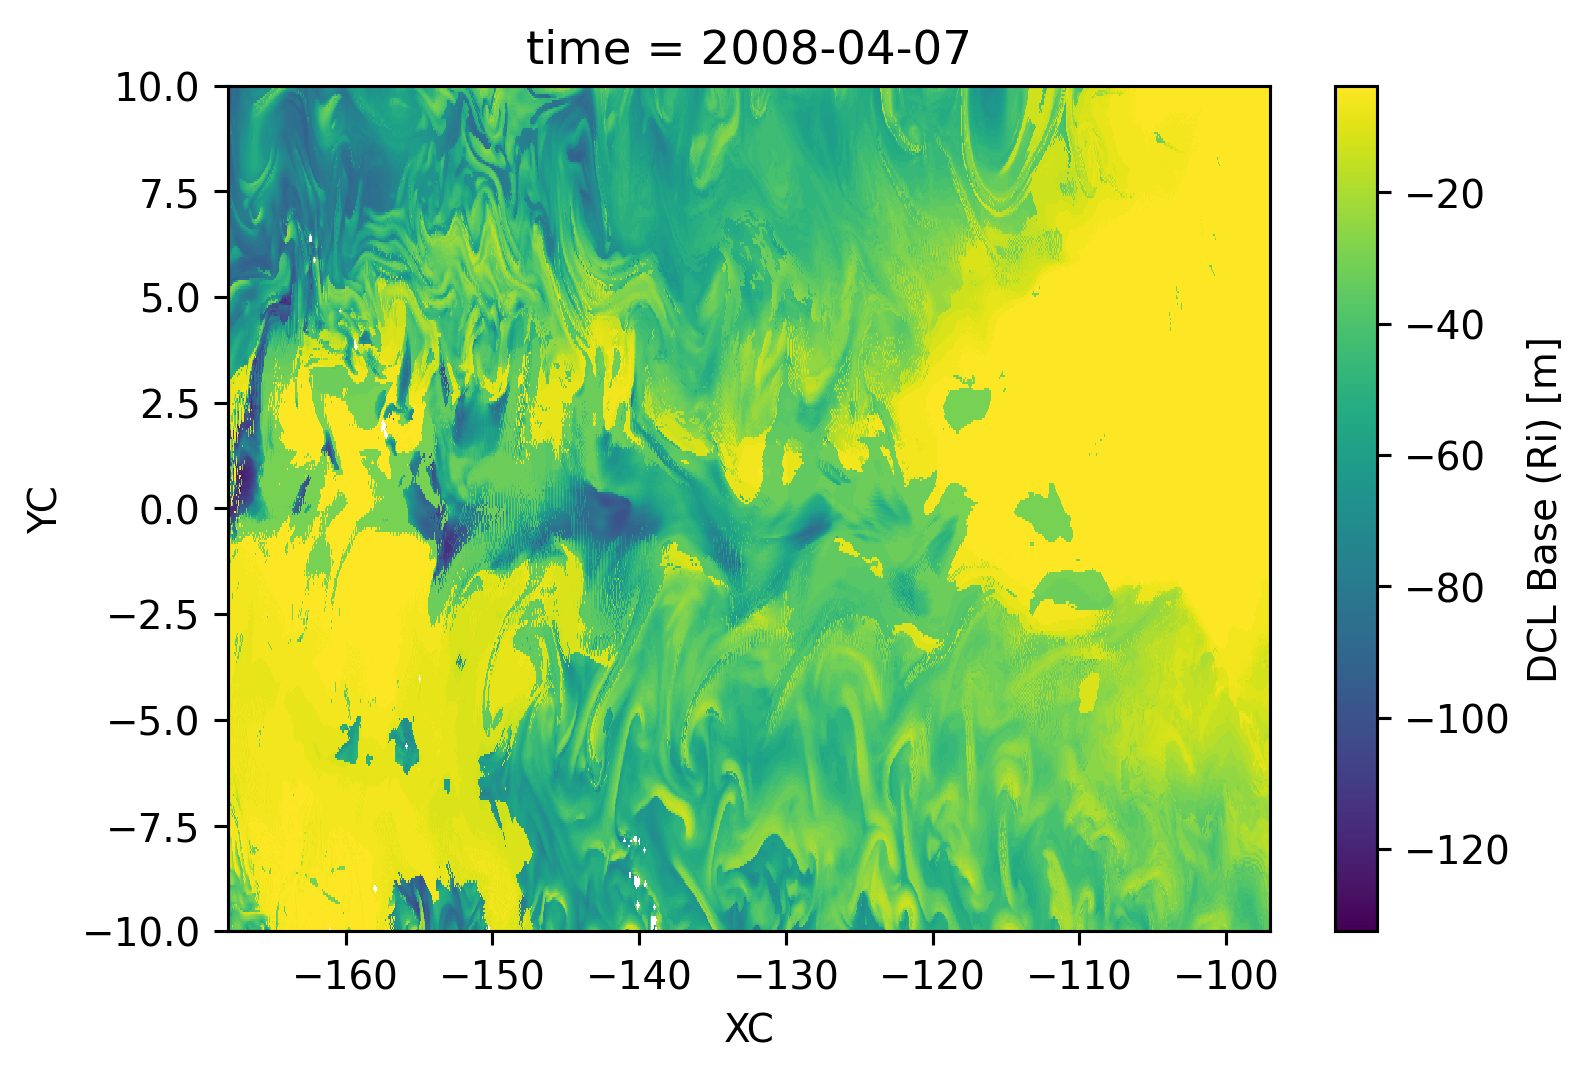

In [69]:
ds.dcl_base.isel(time=100).cf.plot()

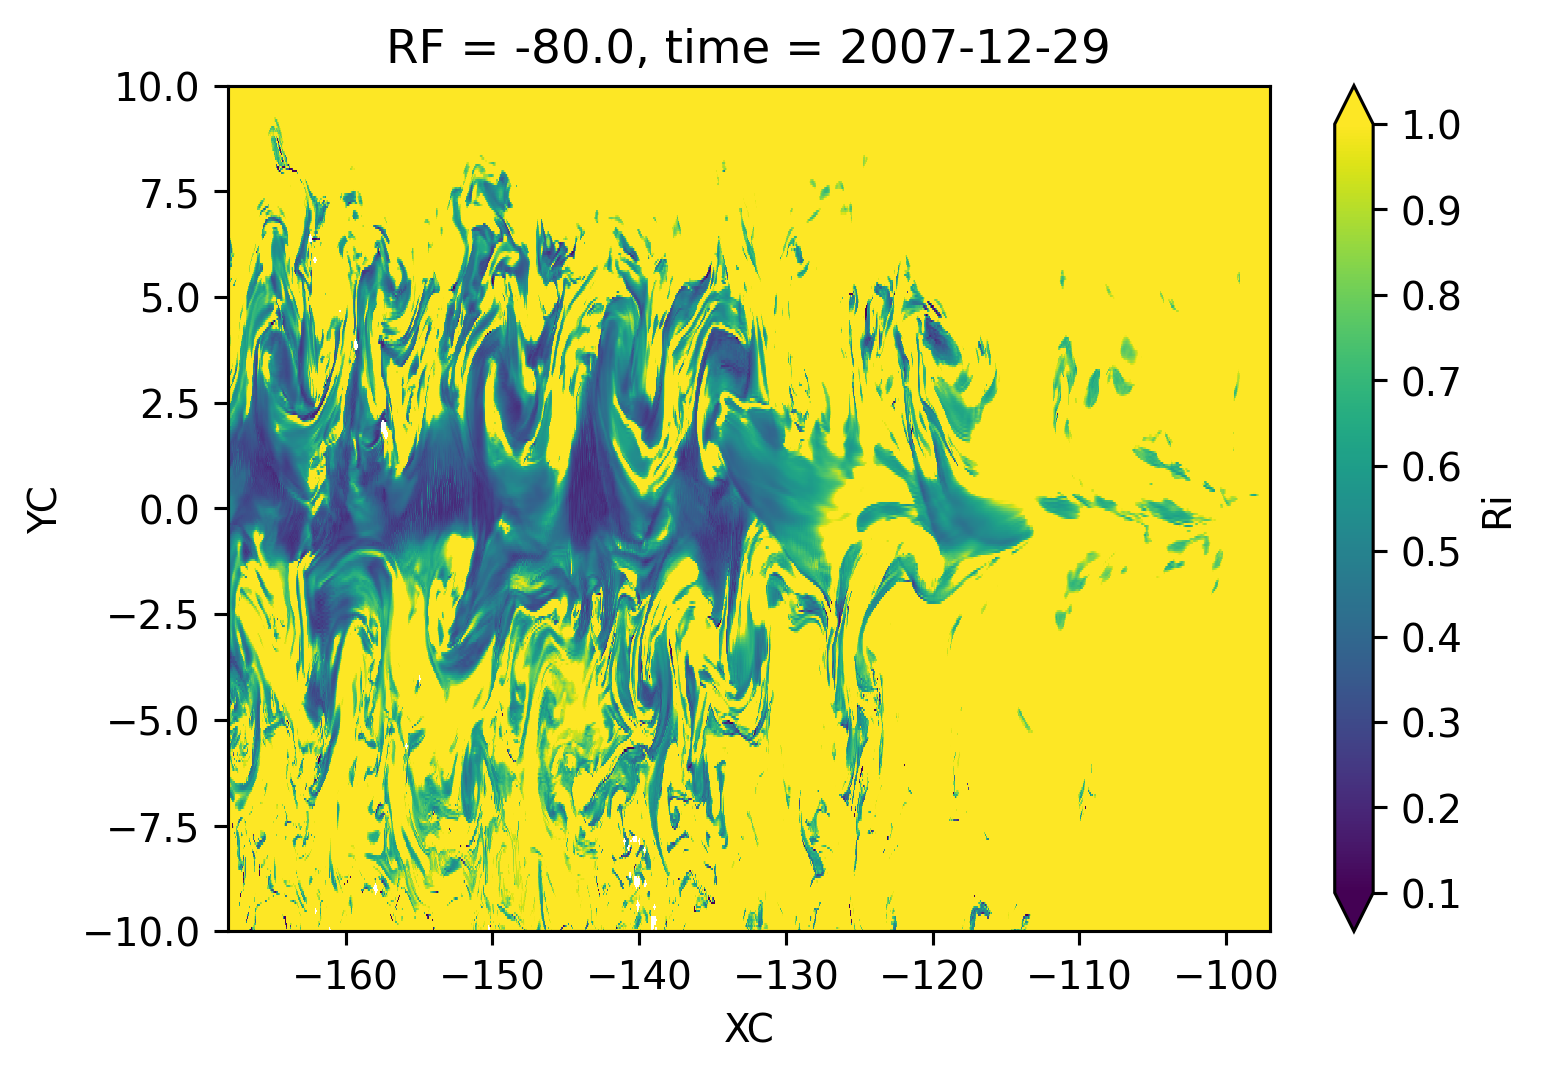

In [39]:
Ri.cf.sel(Z=-80, method="nearest").plot(vmin=0.1, vmax=1)

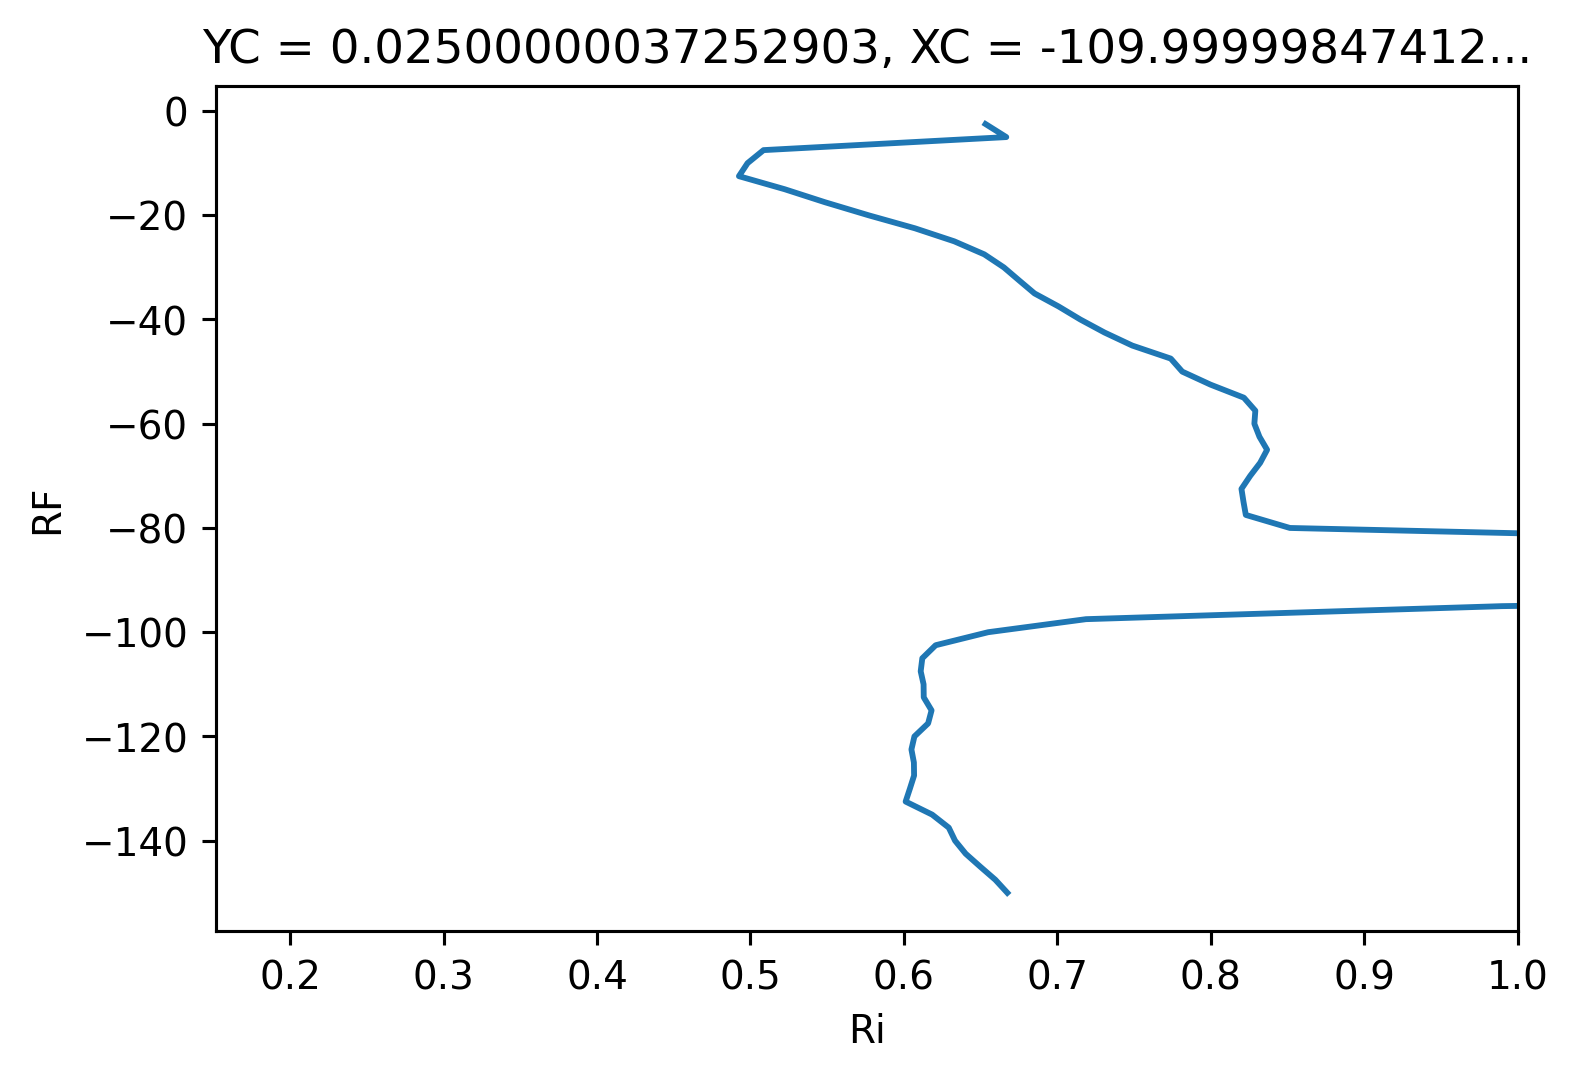

In [41]:
Ri.cf.sel(X=-110, Y=0, method="nearest").cf.sel(Z=slice(-150)).plot(y="RF", xlim=(None, 1))

## POP2: Andre

In [2]:
cluster = distributed.LocalCluster(
    n_workers=36,
    processes=True,
    threads_per_worker=1,
    local_directory="/home/dcherian/.dask_worker/",
    dashboard_address=":9999",
    memory_limit="12GB",
)
cluster

In [3]:
client = distributed.Client(cluster)

In [36]:
import glob

pacificdir = "/project/oce/deppenme/process-dat/more_years/*_19[9]*-*.nc"
sorted(glob.glob(pacificdir))

distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)


['/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-1-10.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-1-15.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-1-20.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-1-25.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-1-30.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-1-5.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-10-12.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-10-17.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-10-2.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-10-22.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-10-27.nc',
 '/project/oce/deppenme/process-dat/more_years/Pac_POP0.1_JRA_IAF_1990-10-7.nc',
 '/project/oce/deppenme/p

In [52]:
def subset(ds):
    return ds[
        [
            "UVEL", "VVEL", "TAREA", "UAREA", 
            "ULONG", "TLONG", "ULAT", "TLAT", 
            "DXU", "DYU", "DXT", "DYT",
            "grav", "Q", "rho_sw",
            "z_t", "z_w", "z_w_bot", "z_w_top",
            "XMXL", "TMXL", "HMXL",
        ]
    ]

In [54]:
gridvars = xr.merge(
    [
        xr.open_dataset("/project/oce/deppenme/helpdir/Pac_DZU_t13.nc").rename({"depth": "z_t"}), 
        xr.open_dataset("/project/oce/deppenme/helpdir/Pac_dzt_t13.nc"),
    ]
)

pacific = xr.open_mfdataset(
    pacificdir,
    parallel=True,
    data_vars="minimal",
    coords="minimal",
    compat="override",
    chunks={"nlon": -1, "nlat": 10, "z_w": 30},
    preprocess=subset,
).update(gridvars)
pacific

<xarray.Dataset>
Dimensions:  (nlat: 305, nlon: 1301, time: 730, z_t: 62, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 297 298 299 300 301 302 303 304
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 ... 1294 1295 1296 1297 1298 1299 1300
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w      (z_w) float32 0.0 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot  (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * time     (time) object 0033-01-06 00:00:00 ... 0043-01-01 00:00:00
Data variables:
    UVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 10, 1301), meta=np.ndarray>
    VVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 10, 1301), meta=np.ndarray>
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    UAREA    (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DXU      (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DYU      (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DXT      (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DYT      (nlat, nlon) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    grav     float64 ...
    Q        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 10, 1301), meta=np.ndarray>
    rho_sw   float64 ...
    XMXL     (time, nlat, nlon) float32 dask.array<chunksize=(1, 10, 1301), meta=np.ndarray>
    TMXL     (time, nlat, nlon) float32 dask.array<chunksize=(1, 10, 1301), meta=np.ndarray>
    HMXL     (time, nlat, nlon) float32 dask.array<chunksize=(1, 10, 1301), meta=np.ndarray>
    DZU      (z_t, nlat, nlon) float32 ...
    DZT      (z_t, nlat, nlon) float32 ...
Attributes:
    title:             g.e20.G.TL319_t13.control.001_hfreq
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-11-17 at 20:33:43.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

Doing this twice so I can use `grid.interp` to generate `DZUW` and `DZTW`

In [55]:
metrics = {
    ('X',): ['DXU', 'DXT'], # X distances 
    ('Y',): ['DYU', 'DYT'], # Y distances 
    ('Z',): ['DZU', 'DZT'], # Z distances 
    ('X', 'Y'): ["UAREA", "TAREA"], # Areas (unnecessary)
}

grid, xpac = pop_tools.to_xgcm_grid_dataset(
    pacific, periodic=False, metrics=metrics, boundary="extrapolate"
)

pacific["DZUW"] = grid.interp(pacific.DZU, "Z")
pacific.DZUW.attrs["grid_loc"] = "3222"
pacific["DZTW"] = grid.interp(pacific.DZT, "Z")
pacific.DZTW.attrs["grid_loc"] = "3112"

metrics = {
    ('X',): ['DXU', 'DXT'], # X distances 
    ('Y',): ['DYU', 'DYT'], # Y distances 
    ('Z',): ['DZU', 'DZT', 'DZUW', 'DZTW'], # Z distances 
    ('X', 'Y'): ["UAREA", "TAREA"], # Areas (unnecessary)
}

grid, xpac = pop_tools.to_xgcm_grid_dataset(
    pacific, periodic=False, metrics=metrics, boundary="extrapolate"
)
xpac.ULONG.load()
xpac.ULONG.data[xpac.ULONG.data > 0] = xpac.ULONG.data[xpac.ULONG.data > 0] - 360
xpac

/home/dcherian/miniconda3/envs/dcpy_old_dask/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


<xarray.Dataset>
Dimensions:  (nlat_t: 305, nlat_u: 305, nlon_t: 1301, nlon_u: 1301, time: 730, z_t: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ULONG    (nlat_u, nlon_u) float64 -200.0 -199.9 -199.8 ... -70.2 -70.1 -70.0
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    ULAT     (nlat_u, nlon_u) float64 -15.03 -15.03 -15.03 ... 15.03 15.03 15.03
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot  (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
  * time     (time) object 0033-01-06 00:00:00 ... 0043-01-01 00:00:00
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 1295 1296 1297 1298 1299 1300 1301
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 298 299 300 301 302 303 304 305
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 1.298e+03 1.3e+03 1.3e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 301.5 302.5 303.5 304.5
Data variables:
    UVEL     (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(1, 62, 10, 1301), meta=np.ndarray>
    VVEL     (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(1, 62, 10, 1301), meta=np.ndarray>
    TAREA    (nlat_t, nlon_t) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    UAREA    (nlat_u, nlon_u) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DXU      (nlat_u, nlon_u) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DYU      (nlat_u, nlon_u) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DXT      (nlat_t, nlon_t) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    DYT      (nlat_t, nlon_t) float64 dask.array<chunksize=(10, 1301), meta=np.ndarray>
    grav     float64 ...
    Q        (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 62, 10, 1301), meta=np.ndarray>
    rho_sw   float64 ...
    XMXL     (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 10, 1301), meta=np.ndarray>
    TMXL     (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 10, 1301), meta=np.ndarray>
    HMXL     (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 10, 1301), meta=np.ndarray>
    DZU      (z_t, nlat_u, nlon_u) float32 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    DZT      (z_t, nlat_t, nlon_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    DZUW     (z_w_top, nlat_u, nlon_u) float32 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    DZTW     (z_w_top, nlat_t, nlon_t) float32 1e+03 1e+03 ... 2.5e+04 2.5e+04
Attributes:
    title:             g.e20.G.TL319_t13.control.001_hfreq
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-11-17 at 20:33:43.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [56]:
#xpac["pden"] = pop_tools.eos(xpac.SALT, xpac.TEMP, depth=xpac.z_t)
xpac["S2"] = grid.derivative(xpac.UVEL, "Z")**2 + grid.derivative(xpac.VVEL, "Z")**2
xpac["N2"] = -1 * xpac.grav / xpac.rho_sw * xpac.Q  #9.81/1025 * grid.derivative(xpac.pden, "Z")
xpac["Ri"] = xpac.N2/grid.interp(xpac.S2, ["X", "Y", "Z"])

distributed.utils_perf - WARNING - full garbage collections took 73% CPU time recently (threshold: 10%)


In [57]:
eq = (
    xpac
    .cf.isel(Y=151)
    .cf.sel(Z=slice(500*100))
    #.chunk({"time": -1,})
)
eq["TLONG"] -= 360
eq["TLONG"] = eq.TLONG.interpolate_na("nlon_t", fill_value="extrapolate")
eq["ULONG"] = eq.ULONG.interpolate_na("nlon_u", fill_value="extrapolate")
eq.Ri

<xarray.DataArray 'Ri' (time: 730, z_t: 33, nlon_t: 1301)>
dask.array<getitem, shape=(730, 33, 1301), dtype=float64, chunksize=(1, 32, 1300), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlon_t) float64 dask.array<chunksize=(1301,), meta=np.ndarray>
    TLAT     (nlon_t) float64 dask.array<chunksize=(1301,), meta=np.ndarray>
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 4.434e+04 4.827e+04
  * time     (time) object 0033-01-06 00:00:00 ... 0043-01-01 00:00:00
    nlat_u   int64 152
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 1.298e+03 1.3e+03 1.3e+03
    nlat_t   float64 151.5
Attributes:
    long_name:  Acceleration Due to Gravity
    units:      centimeter/s^2

In [58]:
Ri_kwargs = dict(
    robust=True, 
    levels=[0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95], 
    cmap=mpl.cm.Spectral_r, 
    cbar_kwargs={"orientation": "horizontal", "shrink": 1, "aspect": 25}
)

distributed.utils_perf - WARNING - full garbage collections took 73% CPU time recently (threshold: 10%)


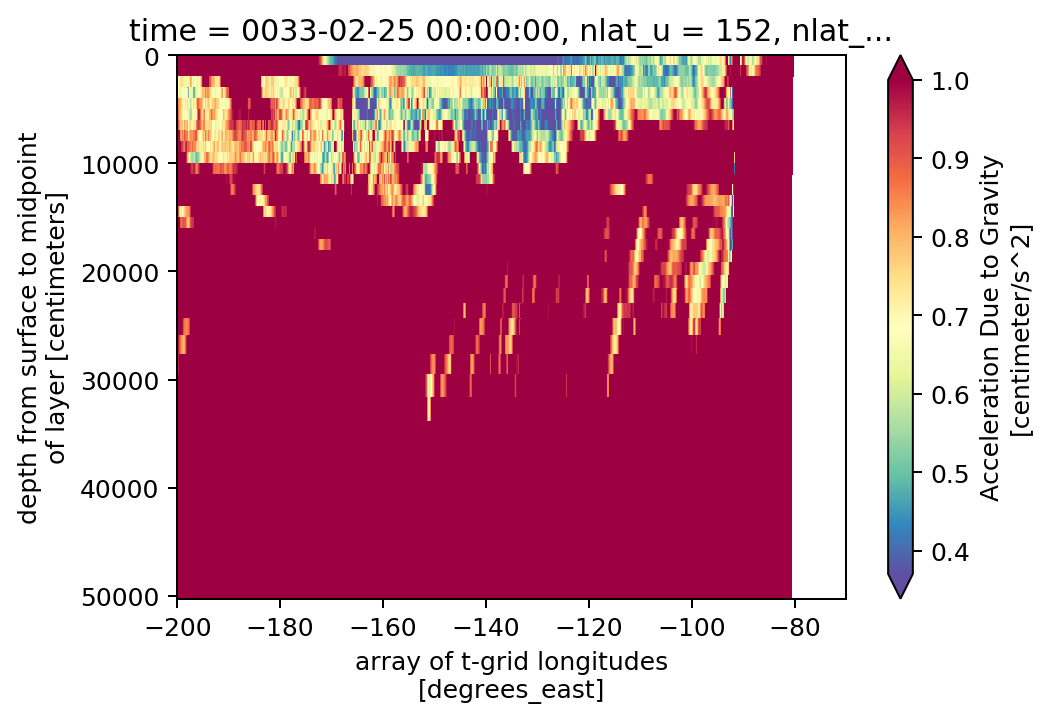

In [50]:
eq.Ri.isel(time=10).cf.plot(x="longitude", y="Z", robust=True, vmax=1, cmap=mpl.cm.Spectral_r)

distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)


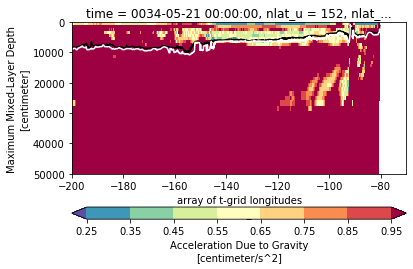

distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)


In [65]:
%matplotlib inline

t = 100
(
    eq.Ri.isel(time=t)
    .cf.plot(x="longitude", y="Z", **Ri_kwargs)
)
eq.HMXL.isel(time=t).cf.plot(x="longitude", color='k', zorder=2)
eq.XMXL.isel(time=t).cf.plot(x="longitude", color='w', zorder=2)

In [63]:
eq.cf.describe()

distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)


Axes:
	X: ['nlon_t', 'nlon_u']
	Y: ['nlat_t', 'nlat_u']
	Z: ['z_t', 'z_w_bot', 'z_w_top']
	T: ['time']

Coordinates:
	longitude: ['TLONG', 'ULONG']
	latitude: ['TLAT', 'ULAT']
	vertical: ['z_t', 'z_w_bot', 'z_w_top']
	time: ['time']

Cell Measures:
	area: []
	volume: []

Standard Names:



In [60]:
medianRi = xr.Dataset()
medianRi["xmxl"] = eq.Ri.where(eq.Ri.cf["vertical"] > eq.XMXL).median("time")
medianRi["hmxl"] = eq.Ri.where(eq.Ri.cf["vertical"] > eq.HMXL).median("time")
medianRi.load()

distributed.utils_perf - WARNING - full garbage collections took 77% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 75% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 75% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 75% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 75% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 75% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.Dataset>
Dimensions:  (nlon_t: 1301, z_t: 33)
Coordinates:
    TLONG    (nlon_t) float64 -200.1 -200.0 -199.9 ... -70.25 -70.15 -70.05
    TLAT     (nlon_t) float64 -0.15 -0.15 -0.15 -0.15 -0.15 ... nan nan nan nan
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 4.434e+04 4.827e+04
    nlat_u   int64 152
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 1.298e+03 1.3e+03 1.3e+03
    nlat_t   float64 151.5
Data variables:
    xmxl     (z_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan nan
    hmxl     (z_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan nan

In [99]:
medianRi.to_netcdf("~/pump/notebooks/median-Ri-POP2.nc")

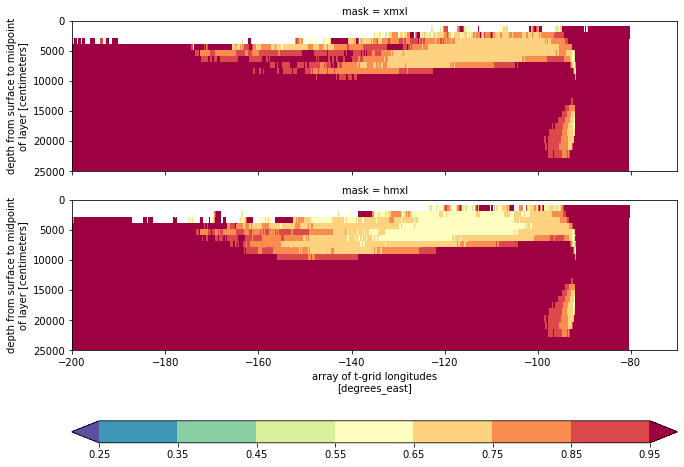

In [98]:
medianRi.to_array("mask").cf.plot(y="Z", x="longitude", row="mask", ylim=(250*100, 0), **Ri_kwargs)

In [69]:
import dask.array as da


# Use a custom array type to know when data is being evaluated
class Array():
    
    def __init__(self, x):
        self.shape = (x.shape[0],)
        self.ndim = x.ndim
        self.dtype = 'bool'
        self.x = x
        
    def __getitem__(self, idx):
        if idx[0].stop > 0:
            print('Evaluating')
        return (self.x > .5).__getitem__(idx)

# Control case -- this shows that the print statement is only reached once
da.from_array(Array(np.random.rand(100))).compute();
# Evaluating

# This usage somehow results in two evaluations of this one array?
ds = xr.Dataset(dict(
    a=('x', da.from_array(Array(np.random.rand(100))))
))
ds.sel(x=ds.a)
# Evaluating
# Evaluating
# <xarray.Dataset>
# Dimensions:  (x: 51)
# Dimensions without coordinates: x
# Data variables:
#     a        (x) bool dask.array<chunksize=(51,), meta=np.ndarray>

# The array is evaluated an extra time for each new variable
ds = xr.Dataset(dict(
    a=('x', da.from_array(Array(np.random.rand(100)))),
    b=(('x', 'y'), da.random.random((100, 10))),
    c=(('x', 'y'), da.random.random((100, 10))),
    d=(('x', 'y'), da.random.random((100, 10))),
))
ds.sel(x=ds.a)

<xarray.Dataset>
Dimensions:  (x: 46, y: 10)
Dimensions without coordinates: x, y
Data variables:
    a        (x) bool dask.array<chunksize=(46,), meta=np.ndarray>
    b        (x, y) float64 dask.array<chunksize=(46, 10), meta=np.ndarray>
    c        (x, y) float64 dask.array<chunksize=(46, 10), meta=np.ndarray>
    d        (x, y) float64 dask.array<chunksize=(46, 10), meta=np.ndarray>

In [94]:
import dask.array as da
import numpy as np

from xarray.tests import raise_if_dask_computes

with raise_if_dask_computes(max_computes=1):
    ds = xr.Dataset(dict(
        a=('x', da.from_array(np.random.rand(100,))),
        b=(('x', 'y'), da.random.random((100, 10))),
        c=(('x', 'y'), da.random.random((100, 10))),
        d=(('x', 'y'), da.random.random((100, 10))),
    ))
    ds.sel(x=(ds.a > 0.5))

RuntimeError: Too many computes. Total: 2 > max: 1.